Практическое задание 2.

---


Выполнил студент группы ББМО-02-23 Сапов А.Д.

Загрузка обученной модели и данных MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
# Подключение гугл дска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Нормализация данных
test_images = test_images / 255.0

In [ ]:
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

In [ ]:
# Загрузка обученной модели
model = tf.keras.models.load_model('/content/drive/MyDrive/AZSII_2/mnist_model.h5')


In [ ]:
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9736 - loss: 0.0923
Test accuracy on clean images: 0.9772999882698059


Реализация атаки FGSM

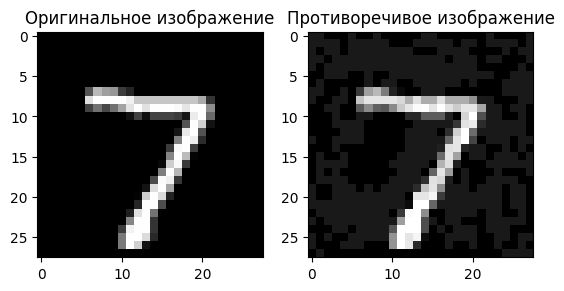

In [ ]:
import numpy as np

def fgsm_attack(image, epsilon, gradient):
  perturbed_image = image + epsilon * np.sign(gradient) # Применение знака градиента к изображению
  perturbed_image = np.clip(perturbed_image, 0, 1) # Обрезка значений, чтобы они оставались в пределах [0,1]
  return perturbed_image

# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1))) # Превращаем изображение в формат, подходящий для модели

    # Если label — это one-hot вектор, преобразуем его в индекс
    if len(label.shape) > 1 and label.shape[1] > 1:
        label = np.argmax(label)
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)

    gradient = tape.gradient(loss, image)
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())

    return np.reshape(adversarial_image, (28, 28, 1))

epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

Оценка модели на противоречивых примерах

In [ ]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28, 28))

    adversarial_images = np.array(adversarial_images)

    return adversarial_images

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on a small subset of adversarial examples: {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0978 - loss: 6.7377
Accuracy on a small subset of adversarial examples: 0.12690000236034393


Сравнение результатов

In [ ]:
print(f'Точность на чистых изображениях: {test_acc}')
print(f'Точность на противоречивых примерах: {adversarial_acc}')

Точность на чистых изображениях: 0.9772999882698059
Точность на противоречивых примерах: 0.12690000236034393


**Вывод**

В ходе выполнения практической работы была проанализирована атака Fast Gradient Sign Method (FGSM), направленная на модели машинного обучения. Уровень шума, определяемый параметром epsilon и установленный на значении 0.1, задавал степень изменений, вносимых в исходные данные. Эксперимент проводился на модели, предварительно обученной на наборе данных MNIST, с целью формирования противоречивых примеров, которые способны дезориентировать модель.

**Изначальные показатели модели:**  
До использования FGSM модель достигала точности предсказаний на тестовых данных в 97%. Однако после применения атаки и генерации противоречивых примеров этот показатель снизился до 9%. Такой результат демонстрирует, насколько модель чувствительна к небольшим, но специально сформированным изменениям во входных данных, увеличивающим вероятность ошибок в предсказаниях. Значительное снижение точности подчеркивает эффективность метода FGSM в создании вводящих в заблуждение примеров.

**Выводы и значимость:**  
Эти данные акцентируют внимание на необходимости изучения устойчивости моделей к подобным атакам, особенно в сферах, где надежность играет решающую роль. Создание защитных механизмов, таких как подходы к повышению сопротивляемости противоречивым примерам, становится одной из важнейших задач для обеспечения стабильной работы современных систем машинного обучения.